# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import os
import shapely
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import urllib
from geopandas import GeoDataFrame

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

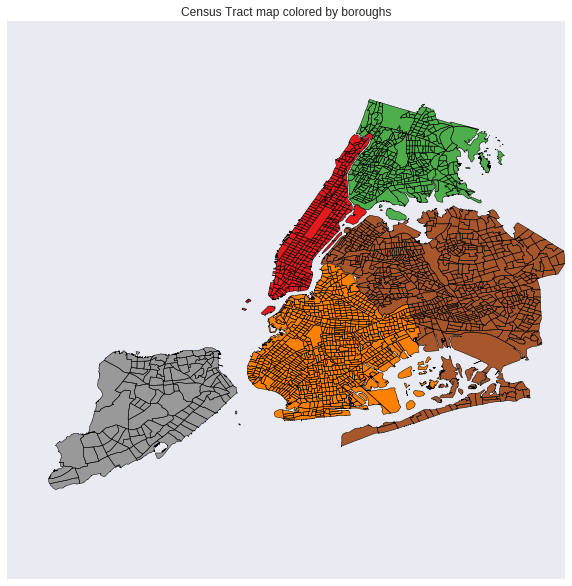

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [7]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [8]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


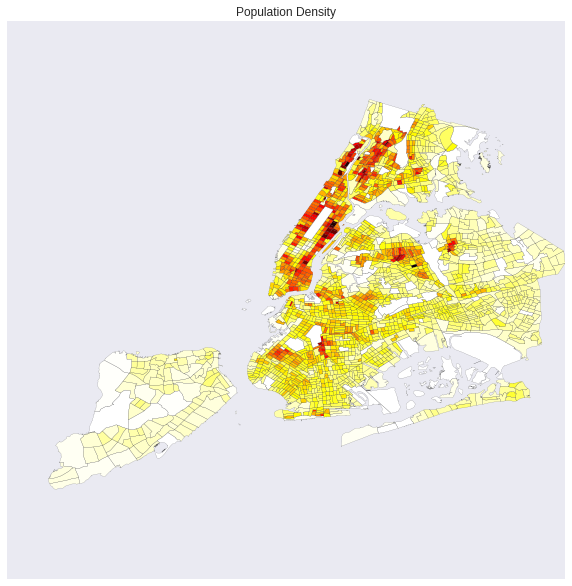

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [10]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


### Wrangling CitiBike data, split into two dataframes (summer & winter)


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

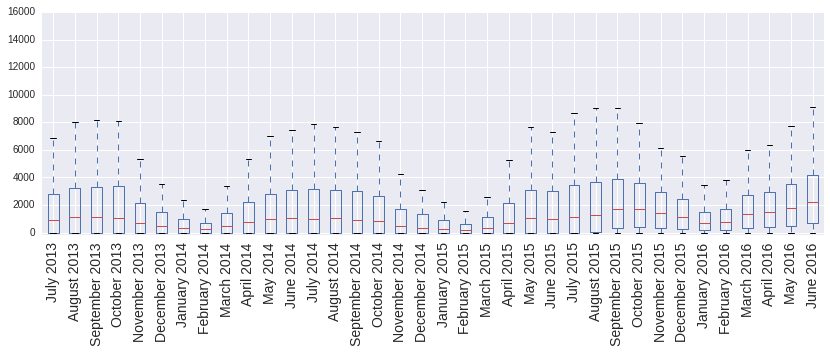

In [11]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


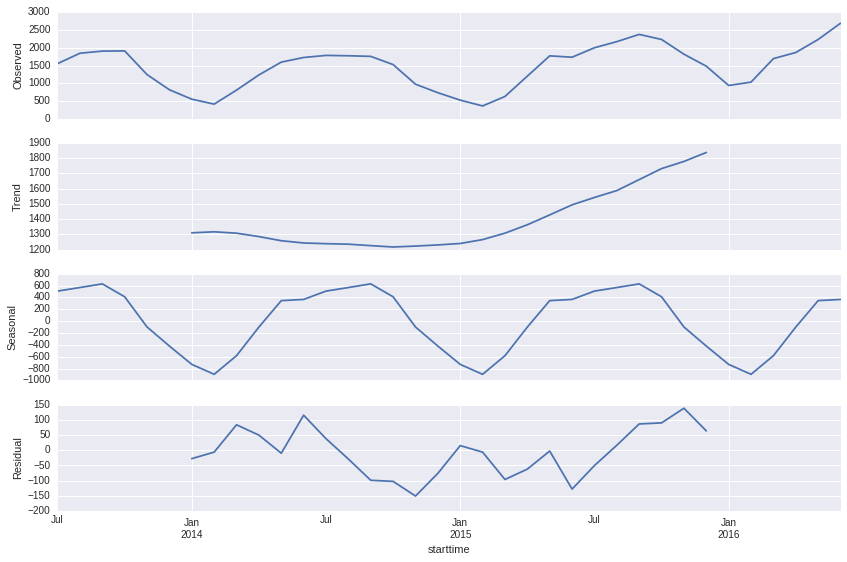

In [12]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [13]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [14]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


In [15]:
BoroCT2010 = pd.read_csv('Data/CT_Shape/R10_BoroCT2010.csv')

### Intersect the two geometries

In [16]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [19]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


In [20]:
df_winsum = df_bike_monthly.copy()

wint = df_bike_monthly[(df_bike_monthly.index.month == 12)  |
                       (df_bike_monthly.index.month == 1)   |            
                       (df_bike_monthly.index.month == 2)   |
                       (df_bike_monthly.index.month == 3)]
                       
summ = df_bike_monthly[(df_bike_monthly.index.month == 6)   |
                       (df_bike_monthly.index.month == 7)   |            
                       (df_bike_monthly.index.month == 8)   |
                       (df_bike_monthly.index.month == 9)]
                       
station_id['Wint_Avg'] = wint.sum()
station_id['Summ_Avg'] = summ.sum()                  

In [21]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,Wint_Avg,Summ_Avg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,13163,30696
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,16113,45966
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,52940,118837
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,19541,44794
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,31319,82749


### Add the seasonal rides to the CT shapefile 

In [22]:
# use the 
temp=station_id[['MonthlyAve', 'Wint_Avg', 'Summ_Avg']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)
temp.head()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,MonthlyAve,Wint_Avg,Summ_Avg,station_id
BoroCT2010,,,,
1009000,69308,13163,30696,1000
1009900,102824,16113,45966,1001
1005700,273525,52940,118837,1002
1001800,101949,19541,44794,1003
1006100,184044,31319,82749,1004


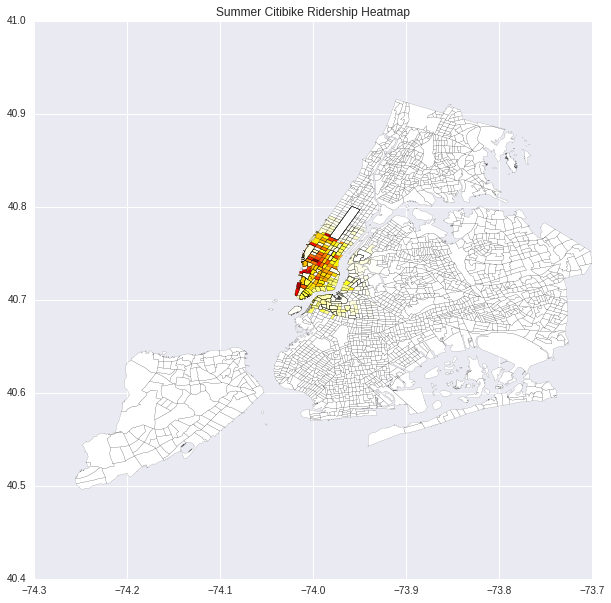

In [30]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='Summ_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Citibike Ridership Heatmap")

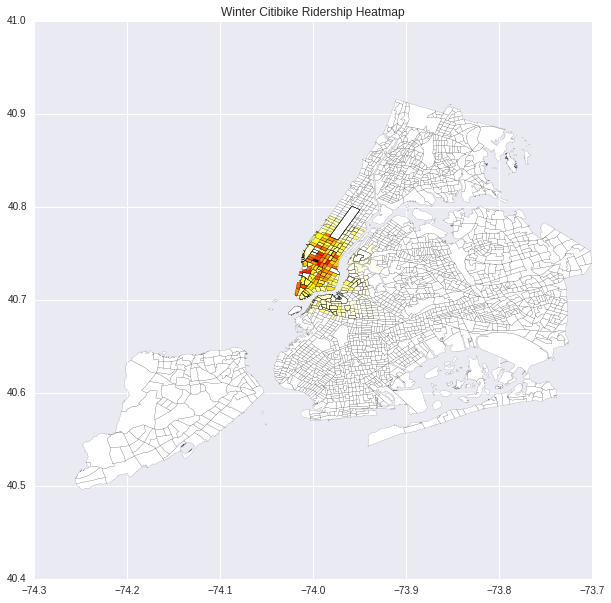

In [31]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='Wint_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Citibike Ridership Heatmap")

### Removing the CTs that are out of zoom boundries

In [33]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [35]:
print "Total number of CTs:", len(ct_shape_MonthlyAve)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2460
Number of zoomed CTs: 543


### Map the seasonal rides 

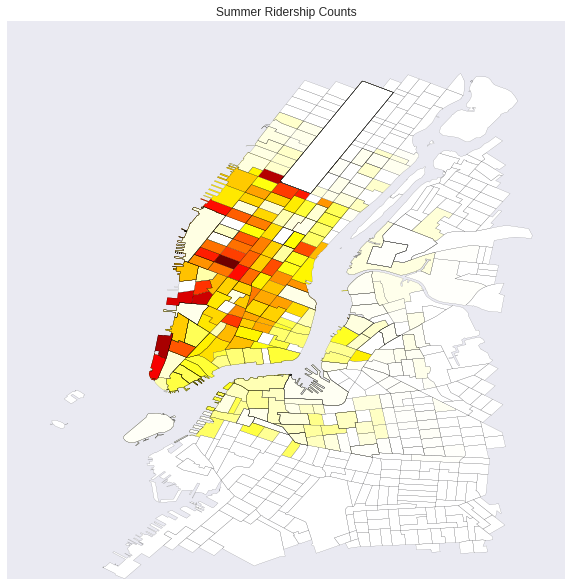

In [36]:
#Summer Rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Summ_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ridership Counts")

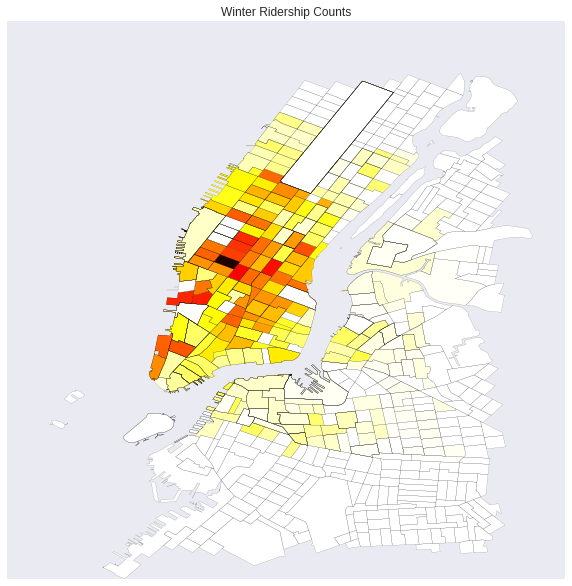

In [37]:
#Winter Rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Wint_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ridership Counts")

### Export Shapefile CTs in the CitiBike Zone

In [38]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [39]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [40]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [41]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [42]:
Wmatrix, ids = qW_CT.full()

In [43]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [44]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [45]:
SummerRide=ct_shape_MonthlyAve_Zoom.Summ_Avg
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

WinterRide=ct_shape_MonthlyAve_Zoom.Wint_Avg
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for mapping

In [47]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print SummerRideLagQ10

WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    88.000                 2
   88.000 < x[i] <=  1511.625                78
 1511.625 < x[i] <=  3075.000                80
 3075.000 < x[i] <=  7551.400                81
 7551.400 < x[i] <= 11627.857                78
11627.857 < x[i] <= 25693.803                79
25693.803 < x[i] <= 37395.214                80
37395.214 < x[i] <= 43198.655                79
43198.655 < x[i] <= 66036.500                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113       

#### Map the monthly rides lag

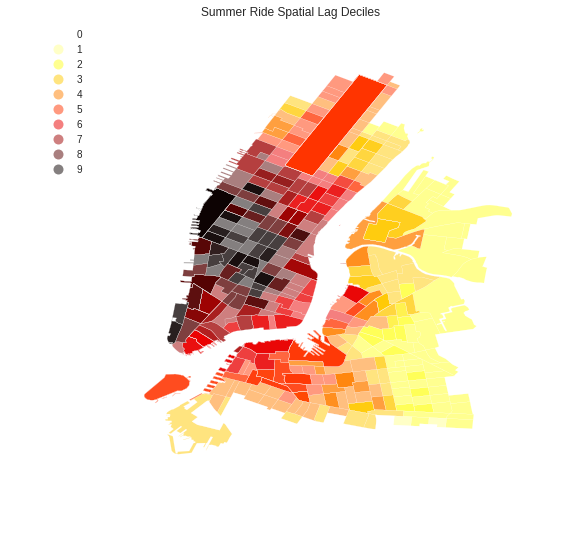

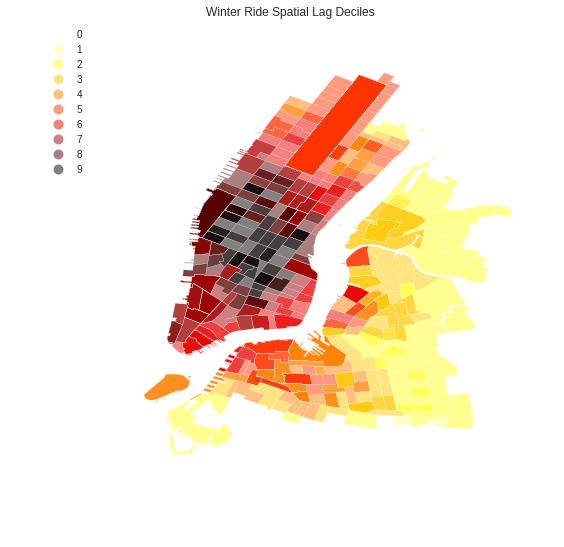

In [49]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [50]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
print b,a 

b_1,a_1 = np.polyfit(SummerRide, SummerRideLag, 1)
print b_1,a_1 

0.643893143126 5682.93107874
0.643893143126 5682.93107874


### Moran Scatterplot

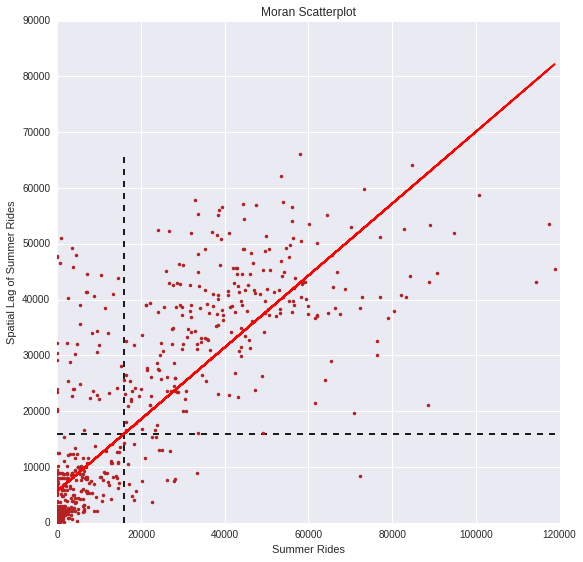

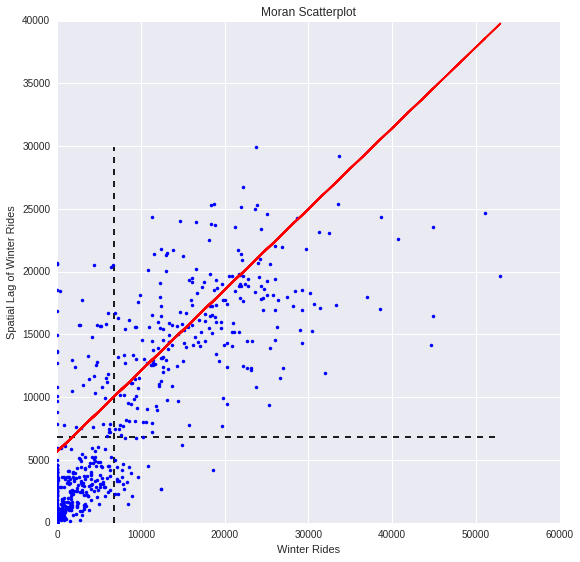

In [52]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='b')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Moran's I

In [54]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [56]:
print I_SummerRide.I, I_SummerRide.p_sim
print I_WinterRide.I, I_WinterRide.p_sim

0.644069499068 0.001
0.662044196711 0.001


Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [57]:
I_SummerRide.sim[0:10]

array([-0.03842598, -0.00671324,  0.01825689,  0.00487339,  0.00981181,
        0.00395733,  0.02735221, -0.00976814, -0.0187165 ,  0.01931884])

In [58]:
I_WinterRide.sim[0:10]

array([ 0.00396992, -0.00141134,  0.02923657, -0.02259105, -0.0066926 ,
       -0.00436624,  0.01805339, -0.03215426, -0.03365152,  0.04315434])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [59]:
import seaborn as sns

(-0.7, 0.7)

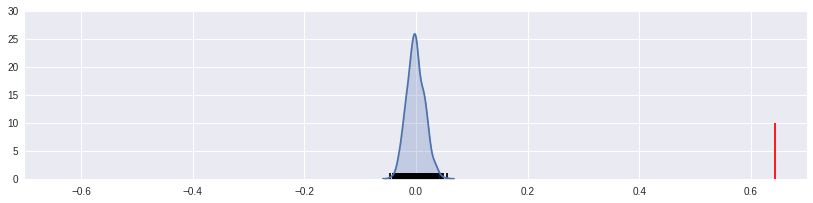

In [61]:
I_SummerRide.sim[0:10]
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

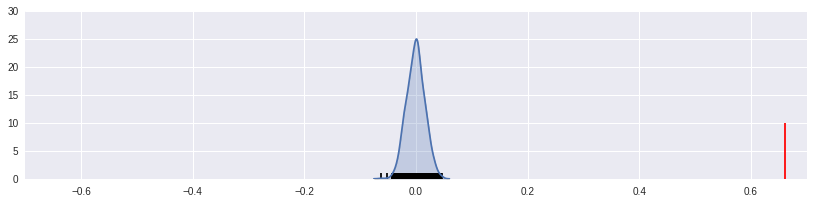

In [62]:
I_WinterRide.sim[0:10]
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

## Local  Spatial Autocorrelation

In [65]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [66]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.179,  0.343,  0.323,  0.373]))

In [67]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [68]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.139,  0.464,  0.475,  0.429]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [69]:
sigs_s = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs_s = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs_s = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs_s = SummerRideLag[LMo_SummerRide.p_sim > .001]

sigs_w = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs_w = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs_w = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs_w = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

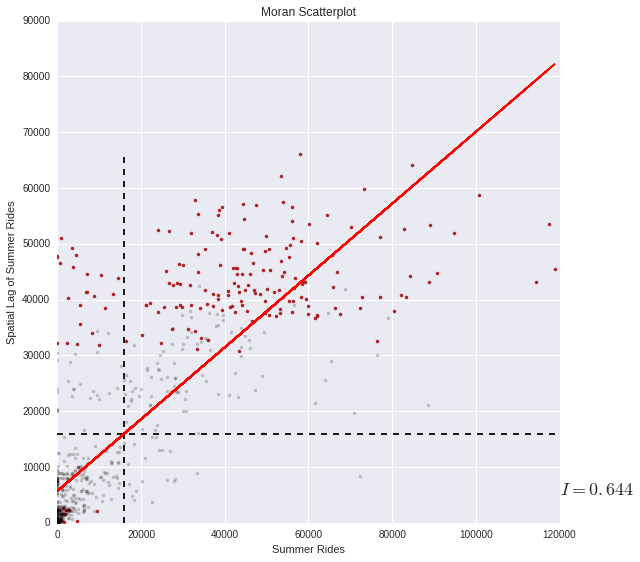

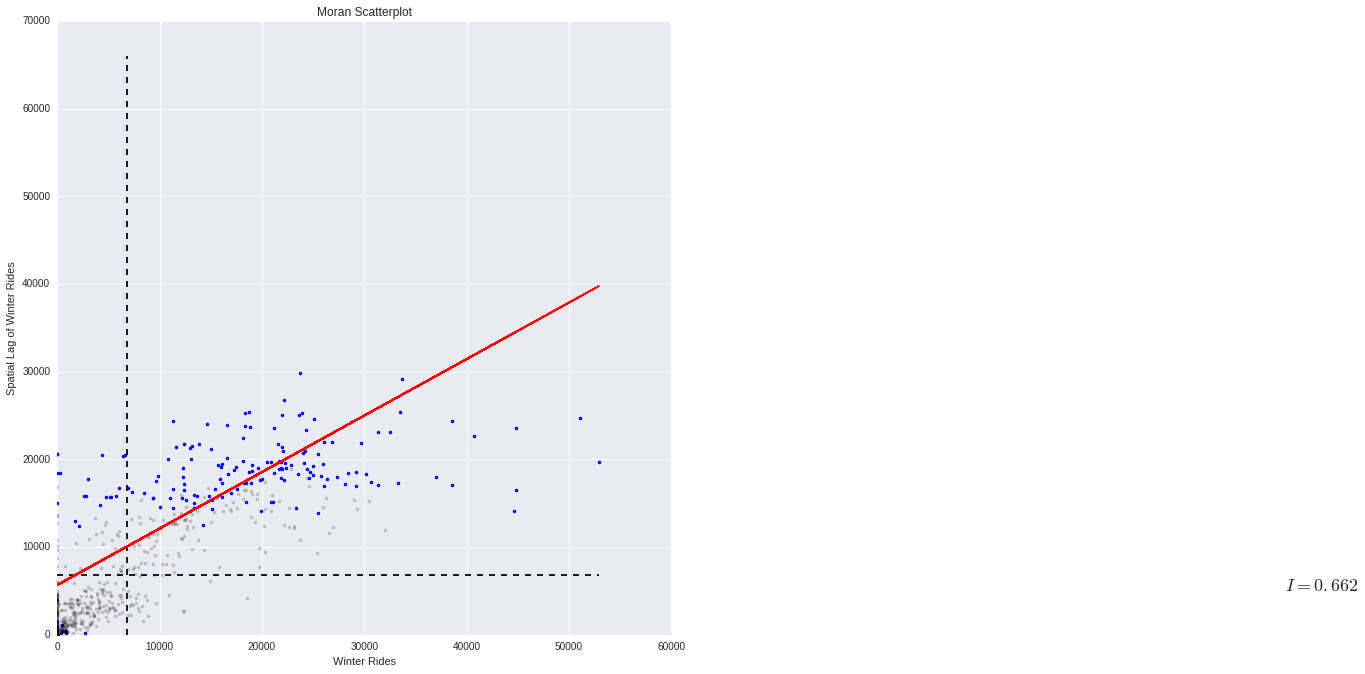

In [75]:
#SUMMER
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_s, W_sigs_s, '.', color='firebrick')
plt.plot(insigs_s, W_insigs_s, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

#WINTER
f, ax = plt.subplots(figsize=(11, 11))
plt.plot(sigs_w, W_sigs_w, '.', color='b')
plt.plot(insigs_w, W_insigs_w, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Hot and Cold spots 

In [77]:
sig_s = LMo_SummerRide.p_sim < 0.01
hotspots_s = LMo_SummerRide.q==1 * sig_s
coldspots_s = LMo_SummerRide.q==3 * sig_s
print "Number of Hotspots:", hotspots_s.sum()
print "Number of Coldspots:", coldspots_s.sum()

Number of Hotspots: 188
Number of Coldspots: 245


In [78]:
sig_w = LMo_WinterRide.p_sim < 0.01
hotspots_w = LMo_WinterRide.q==1 * sig_w
coldspots_w = LMo_WinterRide.q==3 * sig_w
print "Number of Hotspots:", hotspots_w.sum()
print "Number of Coldspots:", coldspots_w.sum()

Number of Hotspots: 194
Number of Coldspots: 215


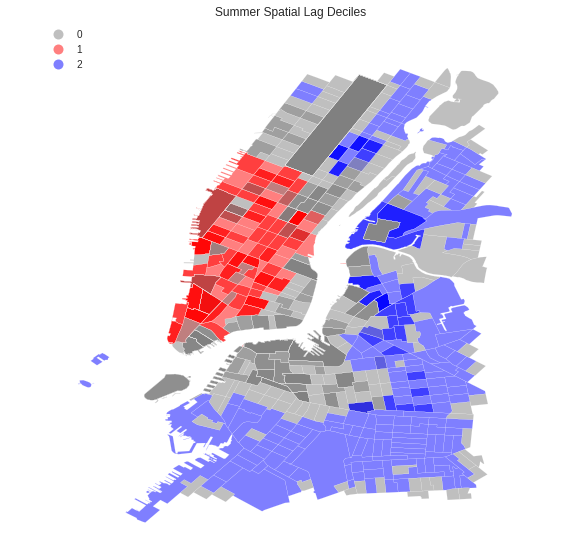

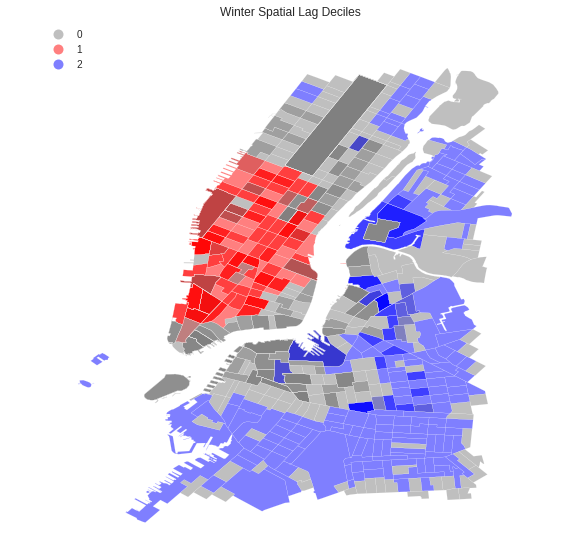

In [79]:
from matplotlib import colors

hcmap_s = colors.ListedColormap(['grey','red','blue'])
hotcold_s = hotspots_s*1 + coldspots_s*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_s).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_s, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Spatial Lag Deciles")

hcmap_w = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w*1 + coldspots_w*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_w).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_w, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Spatial Lag Deciles")